In [17]:
import lifetimes

ModuleNotFoundError: No module named 'seaborn'

# RMDS Workshop 3
## Customer Lifetime Value Modeling

# Why Model Customer Behavior?

- Understanding Typical Patterns of Customer Transaction Rates and Time to Inactivity

- Understanding how much we expect a customer to spend in the next 6 months

- Determining if a customer is permanently inactive or just has not made a transaction recently

# What Type of Data is Required?

## Answer: Transaction Data

In [6]:
from lifetimes.datasets import load_transaction_data
transaction_data = load_transaction_data()

print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


# We need to create an RFM Matrix...


- The R in RFM Matrix represents Recency or how long ago a customer made a *repeat* transaction

- The F in RFM Matrix represents Frequency or how many *repeat* purchases a customer has made

- The M in RFM Matrix represents Monetary value or how much money the customer has spent at this business

- There's also one piece we will need to add to the matrix not in the acrnoym: Length of lifetime

# Let's Practice...

- Write out the Transaction Data with Date in One Column For This Customer
- Compute the R, F, M, and Total Lifetime Value either from the plot or from the Transaction Data 

<img src="demo_ltv_timeline.png">

<img src="demo_ltv_timeline_key.png">

# Transforming Transaction Data to an RFM Matrix

In [28]:
from lifetimes.utils import summary_data_from_transaction_data

rfm_matrix = summary_data_from_transaction_data(transaction_data, 'id', 'date')
print(rfm_matrix)

      frequency  recency      T
id                             
0           0.0      0.0  298.0
1           0.0      0.0  224.0
2           6.0    142.0  292.0
3           0.0      0.0  147.0
4           2.0      9.0  183.0
...         ...      ...    ...
4995        0.0      0.0  336.0
4996        4.0     80.0  293.0
4997        0.0      0.0  304.0
4998        0.0      0.0  306.0
4999        0.0      0.0  165.0

[5000 rows x 3 columns]


What are we missing?

# Switching Datasets

In [12]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
rfm_matrix = load_cdnow_summary_data_with_monetary_value()

print(rfm_matrix.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
3                    0     0.00  38.86            0.00
4                    0     0.00  38.86            0.00
5                    0     0.00  38.86            0.00


# Let's Model!

In order to begin modeling, we first need to examine our model's assumptions.

- Hierarchical Model with Varying Customer Transaction Rate and Dropout Rate (Gamma and Beta, Respectively)

- Each customer's number of transactions is distributed as a Poisson random variable with rate &#955;

- Each customer's activity is distributed as a Geometric random variable with probability *p*

- Dropout Probability and Rate of Transaction and independent of one another

# Let's *actually* Model!

In [14]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm_matrix['frequency'], rfm_matrix['recency'], rfm_matrix['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [15]:
print(bgf.summary)

           coef  se(coef)  lower 95% bound  upper 95% bound
r      0.242593  0.012557         0.217981         0.267205
alpha  4.413532  0.378221         3.672218         5.154846
a      0.792886  0.185719         0.428877         1.156895
b      2.425752  0.705345         1.043276         3.808229


In [29]:
1/(0.24/4.414)

18.391666666666666

# Interpretting Coefficients

- The mean rate of transactions across all customers is *1/(r/alpha)* = 1/(0.24/4.414) = 18.39
- This is interpreted as each customer is expected to make a transaction every 18.39 units of time
- The mean probability of a customer becoming inactive after any purchase is a/(a + b) = 0.79/(0.79 + 2.42) = 0.25
- Another way of thinking about the dropout probability is the mean number of transactions 1/(a/(a+b)) = 4.1

# Did It Work?

There are some graphics we can use to assess model fit.

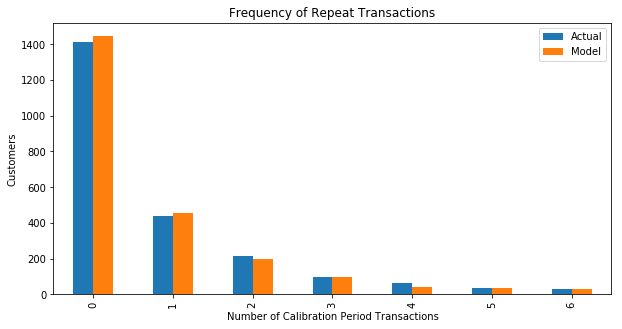

In [20]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, figsize = (10, 5))

There are more graphics including a holdout comparison graphic which we will not cover.

# Predicting Customer Behavior

In [ ]:
t = 10 #predict purchases in 10 periods
individual = rfm_matrix.iloc[20]

print(individual)

In [ ]:
# Predict Number of Purchases in Next 10 Time Periods
prediction = bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
print(prediction)

# Additional Graphics

While beyond the scope of this workshop, some additional data wrangling can happen to produce graphics such as this one displaying the entirety of a customer's "lifetime".

<img src="customer_timeline.png">

# We Missed Something Important...

Monetary Value!

# Modeling Monetary Value

- When modeling Monetary Value it is assumed that each customer's purchase amount is distributed as a Gamma Random Variable
- It is also assumed that the rate and dropout probability are independent of how much a customer spends

Do we think the last assumption is valid?

# Assessing Correlation Between Frequency and Monetary Value

In [24]:
returning_customers_summary = rfm_matrix[rfm_matrix['frequency']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


# Predicting Customer Spend

In [25]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


# Predicting Customer Lifetime Value (Finally)

In [27]:
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm_matrix['frequency'],
    rfm_matrix['recency'],
    rfm_matrix['T'],
    rfm_matrix['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      140.096218
2       18.943466
3       38.180575
4       38.180575
5       38.180575
6     1003.868285
7       28.109681
8       38.180575
9      167.418224
10      38.180575
Name: clv, dtype: float64


# In Review

- We talked about the data necessary for Customer Lifetime Value modeling
- We walked through the necessary data transformation (What matrix?)
- We listed (and questioned!) the model assumptions for the BG/NBD model
- We computed Customer Lifetime Value for a set of customers

# Let's Talk Privacy...

- Additional challenge is posted in the workshop notes.